### Architecture Analysis - BGC Exploratory results
Notebook dedicated to the analysis of the arquitecture of BGCs from metagenomes.

In [1]:
import Bio.SeqIO as SeqIO
import os
import pandas as pd

def parsing_gbk_features(folder_path):

    gbk_files = (
        os.path.join(root, f)
        for root, _, files in os.walk(folder_path)
        for f in files
        if f.endswith((".gbk", ".gbff"))
    )

    bgcs = [
        {
            "file": os.path.basename(gbk),
            "contig": record.id,
            "region": feature.qualifiers.get("region_number", ["NA"])[0],
            "product": feature.qualifiers.get("product", ["unknown"])[0].replace(";", "-"),
            "start": int(feature.location.start),
            "end": int(feature.location.end),
            "length_kb": round(
                (int(feature.location.end) - int(feature.location.start)) / 1000, 2
            )
        }
        for gbk in gbk_files
        for record in SeqIO.parse(gbk, "genbank")
        for feature in record.features
        if feature.type == "region"
    ]

    return pd.DataFrame(bgcs)



In [2]:
bgc_df = parsing_gbk_features("/home/pedro/antismash/resultados/all_BGCs")
bgc_df

,file,contig,region,product,start,end,length_kb
0,MGYG000296065_60.region001.gbk,MGYG000296065_60,1,arylpolyene,0,32165,32.16
1,MGYG000296008_22.region001.gbk,MGYG000296008_22,1,betalactone,0,13321,13.32
2,MGYG000296049_664.region001.gbk,MGYG000296049_664,1,RiPP-like,0,2126,2.13
3,MGYG000296030_3.region001.gbk,MGYG000296030_3,1,terpene,0,20882,20.88
4,MGYG000296065_278.region001.gbk,MGYG000296065_278,1,ectoine,0,5637,5.64
...,...,...,...,...,...,...,...
103,MGYG000296030_5.region001.gbk,MGYG000296030_5,1,terpene,0,24356,24.36
104,MGYG000296040_1.region001.gbk,MGYG000296040_1,1,terpene,0,25821,25.82
105,MGYG000296065_138.region001.gbk,MGYG000296065_138,1,RiPP-like,0,7898,7.90
106,MGYG000296065_40.region001.gbk,MGYG000296065_40,1,resorcinol,0,35859,35.86


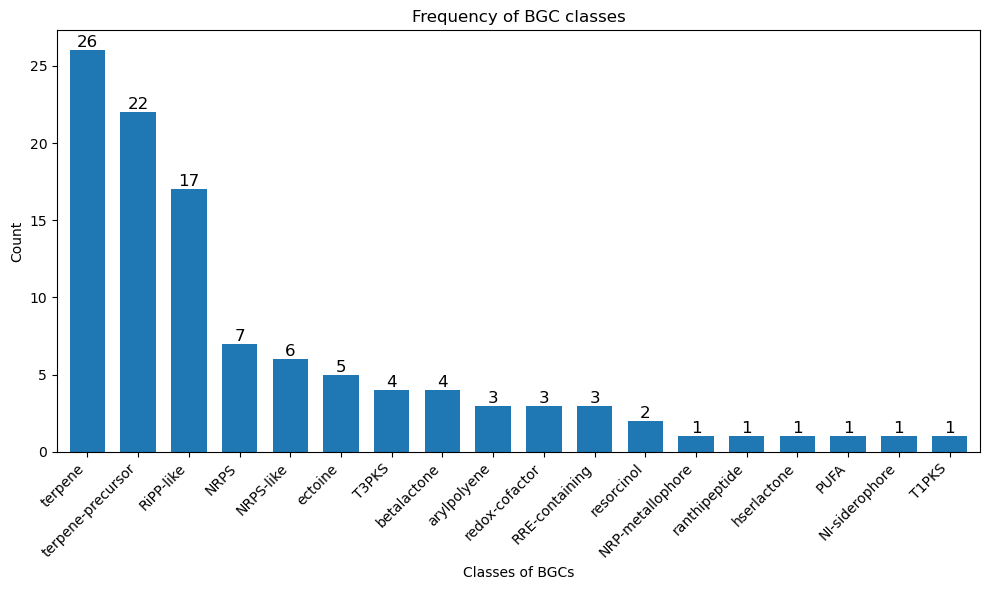

In [3]:
import matplotlib.pyplot as plt

product_counts = bgc_df["product"].value_counts()

plt.figure(figsize=(10, 6))
ax = product_counts.plot(kind="bar", width=0.7)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=12
    )

plt.xticks(rotation=45, ha="right")
plt.xlabel("Classes of BGCs")
plt.ylabel("Count")
plt.title("Frequency of BGC classes")
plt.tight_layout()

plt.show()


In [4]:
import regex as re

bgc_df = bgc_df.sort_values(by="product")
bgc_df = bgc_df.dropna(subset=["product", "length_kb"])
bgc_df = bgc_df.rename(columns= {"file":"sample"})
bgc_df["sample"] = bgc_df["sample"].str.replace(r"\.gbk$", "", regex=True)
bgc_df

,sample,contig,region,product,start,end,length_kb
88,MGYG000296041_93.region001,MGYG000296041_93,1,NI-siderophore,0,11007,11.01
6,MGYG000296065_8.region001,MGYG000296065_8,1,NRP-metallophore,0,70284,70.28
57,MGYG000296065_82.region001,MGYG000296065_82,1,NRPS,0,26190,26.19
29,MGYG000296065_48.region001,MGYG000296065_48,1,NRPS,0,37538,37.54
95,MGYG000296065_13.region001,MGYG000296065_13,1,NRPS,0,49699,49.70
...,...,...,...,...,...,...,...
68,MGYG000296041_96.region001,MGYG000296041_96,1,terpene-precursor,0,10810,10.81
69,MGYG000296016_89.region001,MGYG000296016_89,1,terpene-precursor,0,12389,12.39
70,MGYG000296015_33.region001,MGYG000296015_33,1,terpene-precursor,0,18172,18.17
92,MGYG000296040_14.region001,MGYG000296040_14,1,terpene-precursor,0,20957,20.96


### Length analysis - Graphs

This section creates graph correspond to the length of BGCs classes.

/tmp/ipykernel_1137732/939131587.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


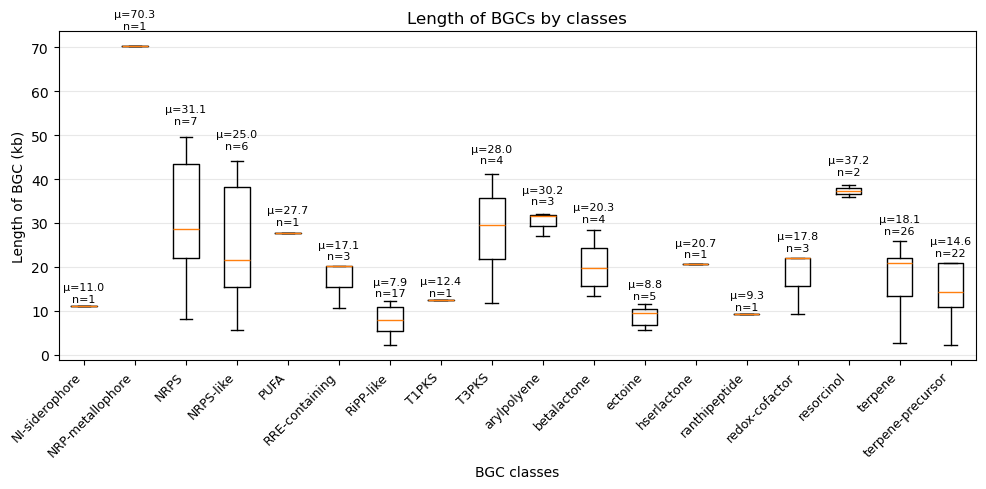

In [5]:
import matplotlib.pyplot as plt
import numpy as np

groups = [group["length_kb"].values for _, group in bgc_df.groupby("product")]
labels = bgc_df["product"].unique()

fig, ax = plt.subplots(figsize = (10,5)) 

for i, group in enumerate(groups, start=1):
    mean_val = np.mean(group)
    n = len(group)

    ax.text(
        i,
        max(group) * 1.05,  
        f"μ={mean_val:.1f}\nn={n}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.grid(True, linestyle='-', axis="y", color='lightgrey', alpha=0.5)
plt.boxplot(groups, labels=labels, showfliers=False)
plt.xticks(rotation=45, ha = "right", fontsize = 9)
plt.ylabel("Length of BGC (kb)")
plt.xlabel("BGC classes")
plt.title("Length of BGCs by classes")
plt.tight_layout()
plt.show()


In [6]:
# Most present classes only
classes = [
    "terpene",
    "terpene-precursor",
    "RiPP-like",
    "NRPS",
    "NRPS-like",
    "ectoine",
    "T3PKS",
    "betalactone"
]

bgc_df_most_present_classes = bgc_df[
    bgc_df["product"].isin(classes)
]
bgc_df_most_present_classes

,sample,contig,region,product,start,end,length_kb
57,MGYG000296065_82.region001,MGYG000296065_82,1,NRPS,0,26190,26.19
29,MGYG000296065_48.region001,MGYG000296065_48,1,NRPS,0,37538,37.54
95,MGYG000296065_13.region001,MGYG000296065_13,1,NRPS,0,49699,49.70
23,MGYG000296065_23.region001,MGYG000296065_23,1,NRPS,0,49335,49.34
17,MGYG000296065_239.region001,MGYG000296065_239,1,NRPS,0,8267,8.27
...,...,...,...,...,...,...,...
68,MGYG000296041_96.region001,MGYG000296041_96,1,terpene-precursor,0,10810,10.81
69,MGYG000296016_89.region001,MGYG000296016_89,1,terpene-precursor,0,12389,12.39
70,MGYG000296015_33.region001,MGYG000296015_33,1,terpene-precursor,0,18172,18.17
92,MGYG000296040_14.region001,MGYG000296040_14,1,terpene-precursor,0,20957,20.96


/tmp/ipykernel_1137732/1863719521.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


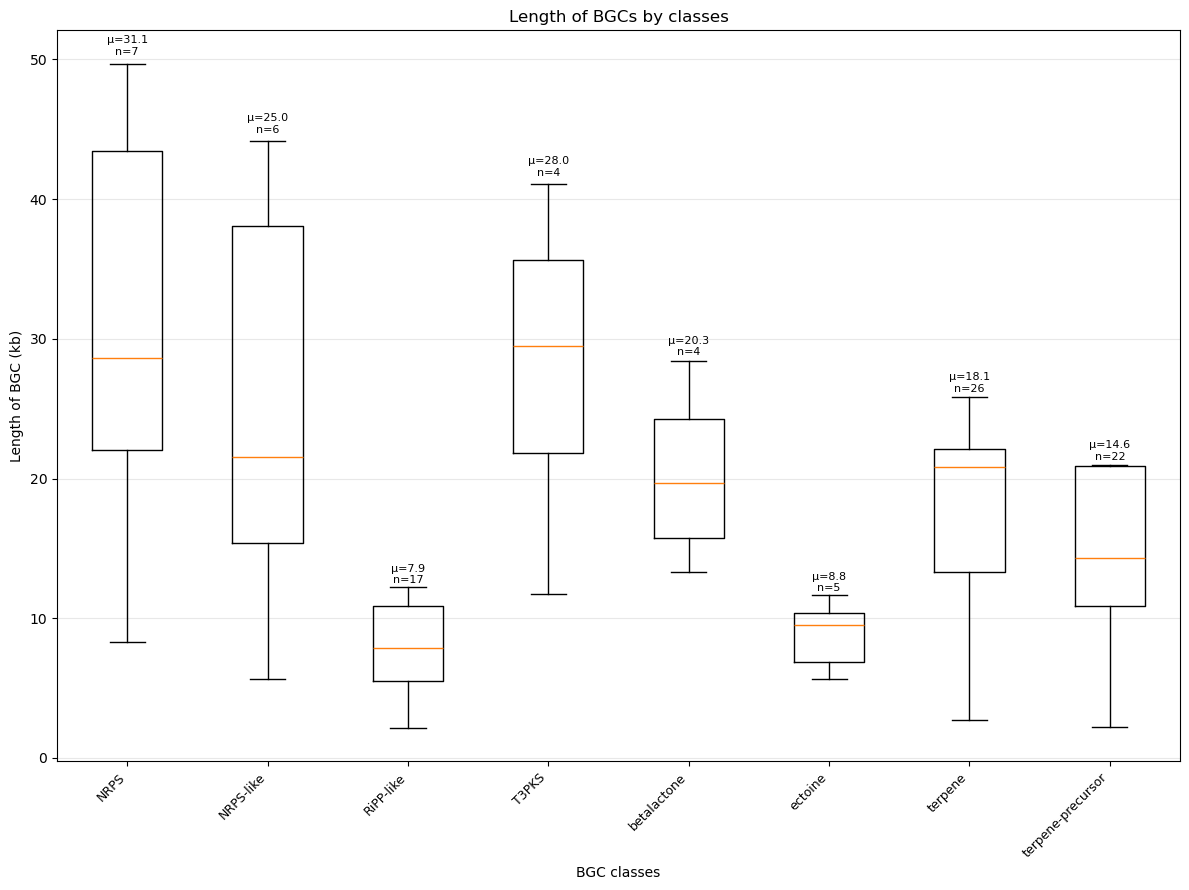

In [7]:
groups = [group["length_kb"].values for _, group in bgc_df_most_present_classes.groupby("product")]
labels = bgc_df_most_present_classes["product"].unique()

fig, ax = plt.subplots(figsize = (12,9)) 

for i, group in enumerate(groups, start=1):
    mean_val = np.mean(group)
    n = len(group)

    ax.text(
        i,
        max(group) * 1.01,  
        f"μ={mean_val:.1f}\nn={n}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.grid(True, linestyle='-', axis="y", color='lightgrey', alpha=0.5)
plt.boxplot(groups, labels=labels, showfliers=False)
plt.xticks(rotation=45, ha = "right", fontsize = 9)
plt.ylabel("Length of BGC (kb)")
plt.xlabel("BGC classes")
plt.title("Length of BGCs by classes")
plt.tight_layout()
plt.show()

### CDS count analysis - Graph

Here we create graphs that represent the quantity of CDS in each BGC class.

In [8]:
def count_cds_in_gbk(folder_path):
    """
    Count the total number of CDS features per sample
    across all GenBank files (.gbk, .gbff) in a folder (recursively).
    """
    results = []

    for root, _, files in os.walk(folder_path):
        for f in files:
            if f.endswith((".gbk", ".gbff")):
                gbk_path = os.path.join(root, f)

                sample = os.path.splitext(f)[0]
                cds_count = 0

                for record in SeqIO.parse(gbk_path, "genbank"):
                    cds_count += sum(
                        1
                        for feature in record.features
                        if feature.type == "CDS"
                    )

                results.append({
                    "sample": sample,
                    "total_cds": cds_count
                })

    return pd.DataFrame(results)



In [9]:
cds_count = count_cds_in_gbk("/home/pedro/antismash/resultados/all_BGCs")
cds_count

,sample,total_cds
0,MGYG000296065_60.region001,36
1,MGYG000296008_22.region001,17
2,MGYG000296049_664.region001,3
3,MGYG000296030_3.region001,21
4,MGYG000296065_278.region001,7
...,...,...
103,MGYG000296030_5.region001,24
104,MGYG000296040_1.region001,22
105,MGYG000296065_138.region001,8
106,MGYG000296065_40.region001,31


In [10]:
bgc_df_with_cds = pd.merge(bgc_df, cds_count, how="inner", on= "sample")
bgc_df_with_cds

,sample,contig,region,product,start,end,length_kb,total_cds
0,MGYG000296041_93.region001,MGYG000296041_93,1,NI-siderophore,0,11007,11.01,10
1,MGYG000296065_8.region001,MGYG000296065_8,1,NRP-metallophore,0,70284,70.28,40
2,MGYG000296065_82.region001,MGYG000296065_82,1,NRPS,0,26190,26.19,15
3,MGYG000296065_48.region001,MGYG000296065_48,1,NRPS,0,37538,37.54,6
4,MGYG000296065_13.region001,MGYG000296065_13,1,NRPS,0,49699,49.70,23
...,...,...,...,...,...,...,...,...
103,MGYG000296041_96.region001,MGYG000296041_96,1,terpene-precursor,0,10810,10.81,12
104,MGYG000296016_89.region001,MGYG000296016_89,1,terpene-precursor,0,12389,12.39,12
105,MGYG000296015_33.region001,MGYG000296015_33,1,terpene-precursor,0,18172,18.17,14
106,MGYG000296040_14.region001,MGYG000296040_14,1,terpene-precursor,0,20957,20.96,23


/tmp/ipykernel_1137732/3707137144.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


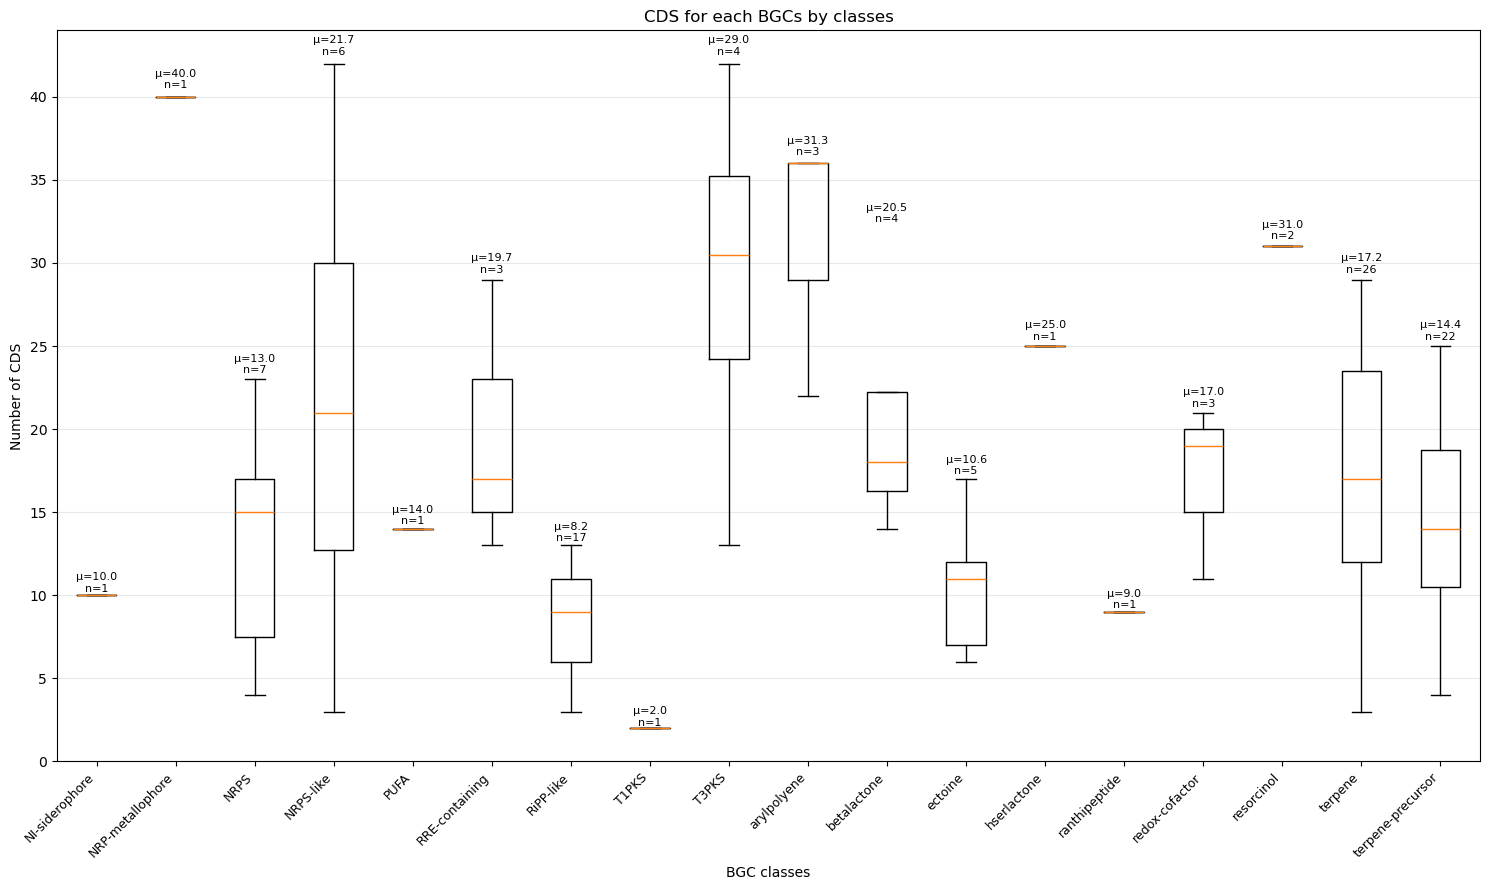

In [11]:
groups = [group["total_cds"].values for _, group in bgc_df_with_cds.groupby("product")]
labels = bgc_df["product"].unique()

fig, ax = plt.subplots(figsize = (15,9)) 

for i, group in enumerate(groups, start=1):
    mean_val = np.mean(group)
    n = len(group)

    ax.text(
        i,
        max(group) * 1.01,  
        f"μ={mean_val:.1f}\nn={n}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.grid(True, linestyle='-', axis="y", color='lightgrey', alpha=0.5)
plt.boxplot(groups, labels=labels, showfliers=False)
plt.xticks(rotation=45, ha = "right", fontsize = 9)
plt.ylabel("Number of CDS")
plt.xlabel("BGC classes")
plt.title("CDS for each BGCs by classes")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1137732/4113650655.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


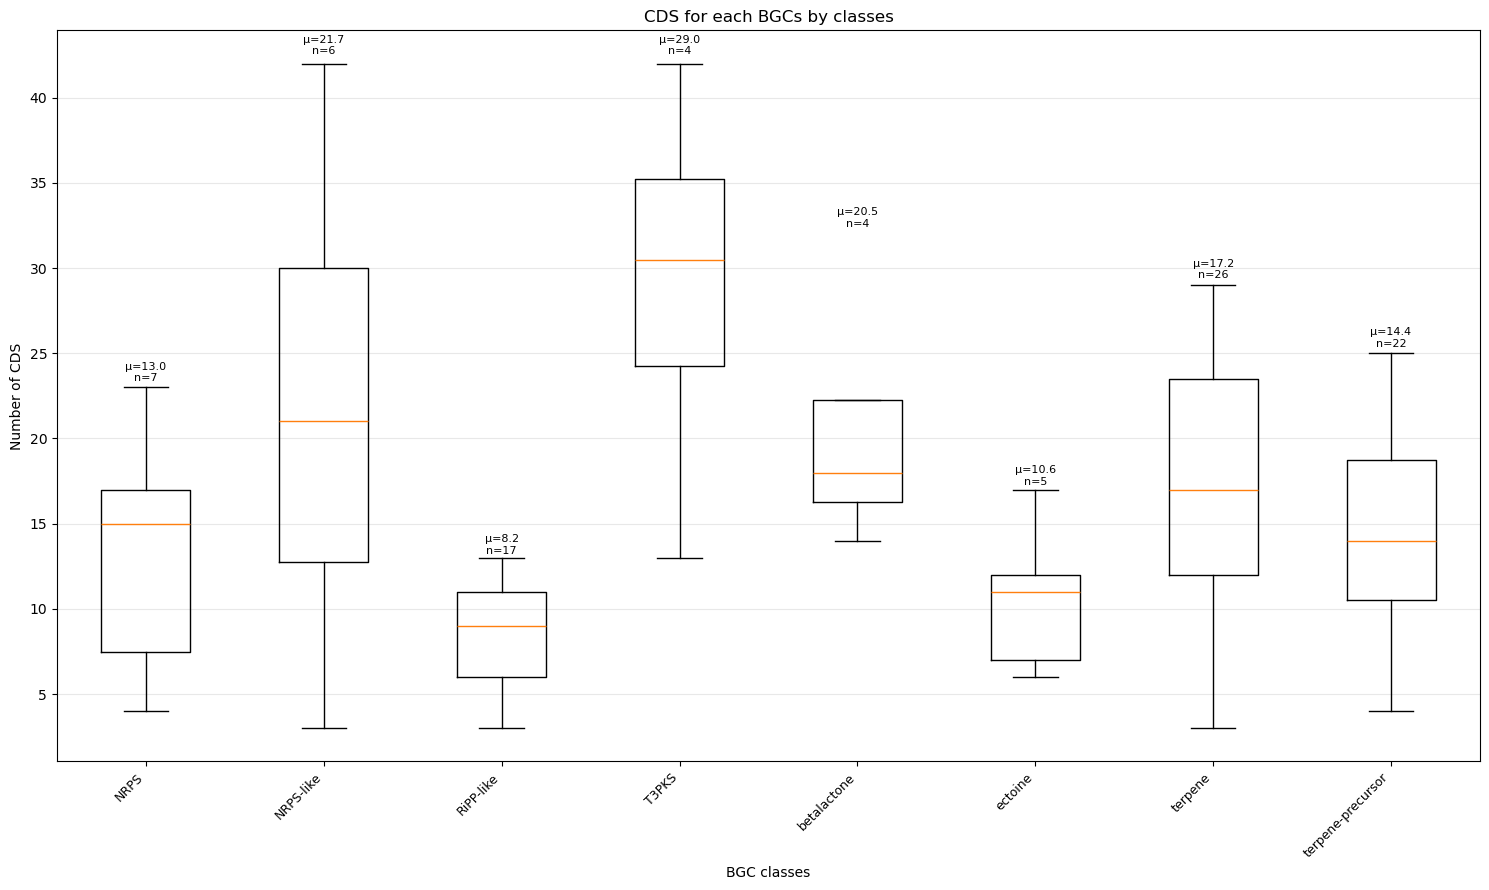

In [12]:
bgc_df_with_cds_most_present_classes = bgc_df_with_cds[
    bgc_df_with_cds["product"].isin(classes)
]

groups = [group["total_cds"].values for _, group in bgc_df_with_cds_most_present_classes.groupby("product")]
labels = bgc_df_with_cds_most_present_classes["product"].unique()

fig, ax = plt.subplots(figsize = (15,9)) 

for i, group in enumerate(groups, start=1):
    mean_val = np.mean(group)
    n = len(group)

    ax.text(
        i,
        max(group) * 1.01,  
        f"μ={mean_val:.1f}\nn={n}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.grid(True, linestyle='-', axis="y", color='lightgrey', alpha=0.5)
plt.boxplot(groups, labels=labels, showfliers=False)
plt.xticks(rotation=45, ha = "right", fontsize = 9)
plt.ylabel("Number of CDS")
plt.xlabel("BGC classes")
plt.title("CDS for each BGCs by classes")
plt.tight_layout()
plt.show()

### BGC gene kind analysis - Functions of the CDS

In this section we analize the results of "gene_kind" feature, presented in the gbk files. This information categorize all CDS by function.

In [13]:
def extract_gene_kind_from_bgcs(folder_path):
    """
    Percorre todos os arquivos GenBank (.gbk/.gbff) do antiSMASH em uma pasta
    e extrai a informação 'gene_kind' de todos os CDS pertencentes a BGCs.
    """

    data = [
        {
            "file": file,
            "contig": record.id,
            "region": region.qualifiers.get("region_number", ["NA"])[0],
            "cds_start": int(cds.location.start),
            "cds_end": int(cds.location.end),
            "gene_kind": cds.qualifiers.get("gene_kind", ["unknown"])[0]
        }
        for root, _, files in os.walk(folder_path)
        for file in files
        if file.endswith((".gbk", ".gbff"))
        for record in SeqIO.parse(os.path.join(root, file), "genbank")
        for region in (f for f in record.features if f.type == "region")
        for cds in (
            cds for cds in record.features
            if cds.type == "CDS"
            and int(cds.location.start) >= int(region.location.start)
            and int(cds.location.end) <= int(region.location.end)
        )
    ]

    return pd.DataFrame(data)


In [14]:
df_gene_kind = extract_gene_kind_from_bgcs("/home/pedro/antismash/resultados/all_BGCs")
df_gene_kind

,file,contig,region,cds_start,cds_end,gene_kind
0,MGYG000296065_60.region001.gbk,MGYG000296065_60,1,166,616,unknown
1,MGYG000296065_60.region001.gbk,MGYG000296065_60,1,567,738,unknown
2,MGYG000296065_60.region001.gbk,MGYG000296065_60,1,779,2177,unknown
3,MGYG000296065_60.region001.gbk,MGYG000296065_60,1,2176,3316,unknown
4,MGYG000296065_60.region001.gbk,MGYG000296065_60,1,3264,3702,unknown
...,...,...,...,...,...,...
1737,MGYG000296041_38.region001.gbk,MGYG000296041_38,1,3759,3867,unknown
1738,MGYG000296041_38.region001.gbk,MGYG000296041_38,1,3824,4958,unknown
1739,MGYG000296041_38.region001.gbk,MGYG000296041_38,1,5000,6671,biosynthetic
1740,MGYG000296041_38.region001.gbk,MGYG000296041_38,1,6703,8629,biosynthetic-additional


In [15]:
df_gene_kind = df_gene_kind.rename(columns= {"file":"sample"})
df_gene_kind["sample"] = df_gene_kind["sample"].str.replace(r"\.gbk$", "", regex=True)
df_gene_kind

,sample,contig,region,cds_start,cds_end,gene_kind
0,MGYG000296065_60.region001,MGYG000296065_60,1,166,616,unknown
1,MGYG000296065_60.region001,MGYG000296065_60,1,567,738,unknown
2,MGYG000296065_60.region001,MGYG000296065_60,1,779,2177,unknown
3,MGYG000296065_60.region001,MGYG000296065_60,1,2176,3316,unknown
4,MGYG000296065_60.region001,MGYG000296065_60,1,3264,3702,unknown
...,...,...,...,...,...,...
1737,MGYG000296041_38.region001,MGYG000296041_38,1,3759,3867,unknown
1738,MGYG000296041_38.region001,MGYG000296041_38,1,3824,4958,unknown
1739,MGYG000296041_38.region001,MGYG000296041_38,1,5000,6671,biosynthetic
1740,MGYG000296041_38.region001,MGYG000296041_38,1,6703,8629,biosynthetic-additional


In [16]:
df_gene_kind_merged = pd.merge(df_gene_kind, bgc_df_with_cds, how="left", on="sample")
df_gene_kind_merged = df_gene_kind_merged.rename(columns= {"start":"bgc_start", "end":"bgc_end", "region_x":"region", "contig_x":"contig"})
df_gene_kind_merged = df_gene_kind_merged.drop(columns=["region_y", "contig_y"])
df_gene_kind_merged

,sample,contig,region,cds_start,cds_end,gene_kind,product,bgc_start,bgc_end,length_kb,total_cds
0,MGYG000296065_60.region001,MGYG000296065_60,1,166,616,unknown,arylpolyene,0,32165,32.16,36
1,MGYG000296065_60.region001,MGYG000296065_60,1,567,738,unknown,arylpolyene,0,32165,32.16,36
2,MGYG000296065_60.region001,MGYG000296065_60,1,779,2177,unknown,arylpolyene,0,32165,32.16,36
3,MGYG000296065_60.region001,MGYG000296065_60,1,2176,3316,unknown,arylpolyene,0,32165,32.16,36
4,MGYG000296065_60.region001,MGYG000296065_60,1,3264,3702,unknown,arylpolyene,0,32165,32.16,36
...,...,...,...,...,...,...,...,...,...,...,...
1737,MGYG000296041_38.region001,MGYG000296041_38,1,3759,3867,unknown,ectoine,0,11671,11.67,11
1738,MGYG000296041_38.region001,MGYG000296041_38,1,3824,4958,unknown,ectoine,0,11671,11.67,11
1739,MGYG000296041_38.region001,MGYG000296041_38,1,5000,6671,biosynthetic,ectoine,0,11671,11.67,11
1740,MGYG000296041_38.region001,MGYG000296041_38,1,6703,8629,biosynthetic-additional,ectoine,0,11671,11.67,11


In [17]:
# Normalização dos grupos de BGCs.

# Contar quantos contigs únicos por product
contig_counts = df_gene_kind_merged.groupby('product')['contig'].nunique()

# Contar quantos genes de cada tipo por product
gene_counts = df_gene_kind_merged.groupby(['product', 'gene_kind']).size().unstack(fill_value=0)

# Dividir cada contagem de gene pelo número de contigs únicos do mesmo product
gene_normalized = gene_counts.div(contig_counts, axis=0)

print(gene_normalized)

gene_kind          biosynthetic  biosynthetic-additional     other  \
product                                                              
NI-siderophore         2.000000                 3.000000  0.000000   
NRP-metallophore       4.000000                 2.000000  2.000000   
NRPS                   1.714286                 1.571429  0.000000   
NRPS-like              1.166667                 7.000000  0.833333   
PUFA                   2.000000                 2.000000  0.000000   
RRE-containing         1.000000                 2.333333  0.333333   
RiPP-like              1.058824                 0.235294  0.117647   
T1PKS                  2.000000                 0.000000  0.000000   
T3PKS                  1.000000                 4.500000  1.500000   
arylpolyene            2.000000                 6.666667  0.000000   
betalactone            2.000000                 6.250000  0.000000   
ectoine                1.000000                 1.600000  0.000000   
hserlactone         

In [18]:
gene_counts

gene_kind,biosynthetic,biosynthetic-additional,other,regulatory,transport,unknown
product,,,,,,
NI-siderophore,2,3,0,0,3,2
NRP-metallophore,4,2,2,2,11,19
NRPS,12,11,0,3,6,59
NRPS-like,7,42,5,3,2,71
PUFA,2,2,0,0,0,10
RRE-containing,3,7,1,3,0,45
RiPP-like,18,4,2,5,1,110
T1PKS,2,0,0,0,0,0
T3PKS,4,18,6,2,4,82


In [19]:
contig_counts

product
NI-siderophore        1
NRP-metallophore      1
NRPS                  7
NRPS-like             6
PUFA                  1
RRE-containing        3
RiPP-like            17
T1PKS                 1
T3PKS                 4
arylpolyene           3
betalactone           4
ectoine               5
hserlactone           1
ranthipeptide         1
redox-cofactor        3
resorcinol            2
terpene              26
terpene-precursor    22
Name: contig, dtype: int64

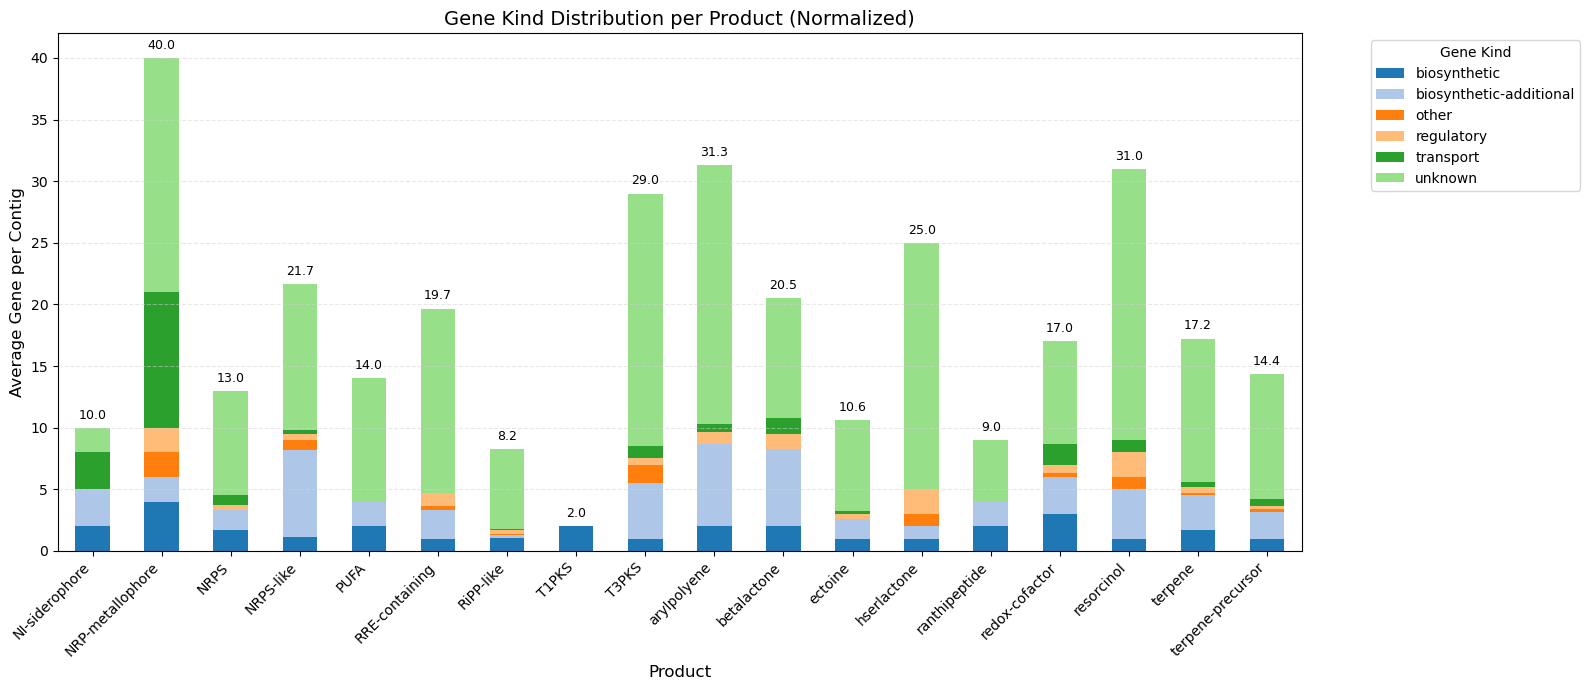

In [20]:
# Definir figura maior
fig, ax = plt.subplots(figsize=(16,7))

# Criar gráfico de barras empilhadas
colors = plt.get_cmap('tab20').colors  # colormap qualitativo
gene_normalized.plot(kind='bar', stacked=True, ax=ax, color=colors[:len(gene_normalized.columns)])

# Melhorar rótulos do eixo x
plt.xticks(rotation=45, ha='right')

# Adicionar grade suave
plt.grid(axis='y', color='lightgrey', linestyle='--', alpha=0.5)

# Eixos e título
ax.set_xlabel('Product', fontsize=12)
ax.set_ylabel('Average Gene per Contig', fontsize=12)
ax.set_title('Gene Kind Distribution per Product (Normalized)', fontsize=14)

# Legenda ajustada
ax.legend(title='Gene Kind', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adicionar valores no topo das barras (somatório por produto)
for i, product in enumerate(gene_normalized.index):
    total = gene_normalized.loc[product].sum()
    ax.text(i, total + 0.5, f'{total:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


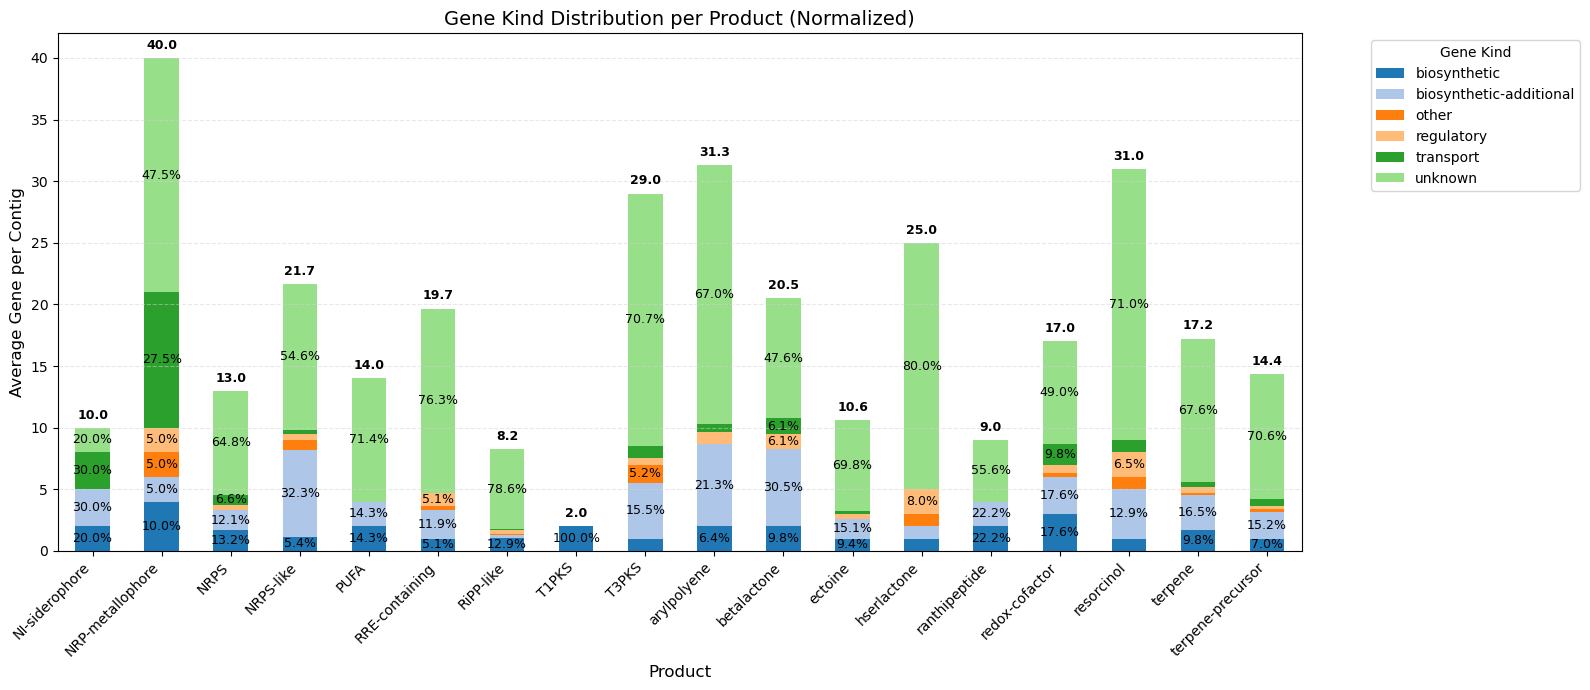

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Criar figura
fig, ax = plt.subplots(figsize=(16,7))

# Plot stacked bar
colors = plt.get_cmap('tab20').colors
gene_normalized.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors[:len(gene_normalized.columns)]
)

# Ajustes de eixo
ax.set_xlabel('Product', fontsize=12)
ax.set_ylabel('Average Gene per Contig', fontsize=12)
ax.set_title('Gene Kind Distribution per Product (Normalized)', fontsize=14)

plt.xticks(rotation=45, ha='right')

# Grade suave
ax.grid(axis='y', linestyle='--', color='lightgrey', alpha=0.5)

# Legenda
ax.legend(
    title='Gene Kind',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=10
)

# ---- Adicionar porcentagens dentro das barras ----
for i, product in enumerate(gene_normalized.index):
    total = gene_normalized.loc[product].sum()
    bottom = 0

    for gene_kind in gene_normalized.columns:
        value = gene_normalized.loc[product, gene_kind]

        if value > 0:
            percent = (value / total) * 100

            # Mostrar apenas se for visualmente legível
            if percent >= 5:
                ax.text(
                    i,
                    bottom + value / 2,
                    f'{percent:.1f}%',
                    ha='center',
                    va='center',
                    fontsize=9,
                    color='black'
                )

            bottom += value

    # Valor total no topo da barra
    ax.text(
        i,
        total + 0.5,
        f'{total:.1f}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


### BGCs domain analysis - Boxplot graphs

In this section we analize the BGCs domains by parsing the "sec_met" region of each CDS.

In [22]:
def biosynthetic_gene_metrics_from_gbks(folder_path):
    """
    Percorre todos os arquivos GenBank (.gbk/.gbff) do antiSMASH em uma pasta
    e calcula métricas de genes biossintéticos por BGC (region).
    """

    results = [
        {
            "file": file,
            "contig": record.id,
            "region": region.qualifiers.get("region_number", ["NA"])[0],
            "n_cds_total": len(cds_in_region),
            "n_cds_biosynthetic": sum(
                1 for cds in cds_in_region
                if any(
                    key in cds.qualifiers
                    for key in ("sec_met", "NRPS_PKS", "aSDomain", "asDomain")
                )
            ),
            "n_cds_accessory": len(cds_in_region)
            - sum(
                1 for cds in cds_in_region
                if any(
                    key in cds.qualifiers
                    for key in ("sec_met", "NRPS_PKS", "aSDomain", "asDomain")
                )
            )
        }
        for root, _, files in os.walk(folder_path)
        for file in files
        if file.endswith((".gbk", ".gbff"))
        for record in SeqIO.parse(os.path.join(root, file), "genbank")
        for region in (f for f in record.features if f.type == "region")
        for cds_in_region in [[
            cds for cds in record.features
            if cds.type == "CDS"
            and int(cds.location.start) >= int(region.location.start)
            and int(cds.location.end) <= int(region.location.end)
        ]]
    ]

    return pd.DataFrame(results)



In [23]:
BIOSYNTHETIC_KEYS = ("sec_met", "NRPS_PKS", "aSDomain", "asDomain")
DOMAIN_KEYS = ("NRPS_PKS", "sec_met_domain")

def is_biosynthetic(cds):
    return any(k in cds.qualifiers for k in BIOSYNTHETIC_KEYS)


def extract_domains(cds):
    return [
        domain
        for k in DOMAIN_KEYS
        for domain in cds.qualifiers.get(k, [])
    ]


def cds_in_region(record, region):
    r_start = int(region.location.start)
    r_end = int(region.location.end)

    return [
        cds for cds in record.features
        if cds.type == "CDS"
        and r_start <= int(cds.location.start)
        and int(cds.location.end) <= r_end
    ]


def biosynthetic_gene_metrics_from_gbks(folder_path):
    """
    Parse antiSMASH GenBank files and compute biosynthetic gene metrics
    and ordered biosynthetic domain architectures per BGC region.
    """

    results = []

    for root, _, files in os.walk(folder_path):
        for file in files:
            if not file.endswith((".gbk", ".gbff")):
                continue

            for record in SeqIO.parse(os.path.join(root, file), "genbank"):
                regions = [f for f in record.features if f.type == "region"]

                for region in regions:
                    cds_list = cds_in_region(record, region)
                    cds_sorted = sorted(cds_list, key=lambda x: int(x.location.start))

                    biosynthetic_cds = [cds for cds in cds_sorted if is_biosynthetic(cds)]

                    results.append({
                        "file": file,
                        "contig": record.id,
                        "region": region.qualifiers.get("region_number", ["NA"])[0],
                        "n_cds_total": len(cds_list),
                        "n_cds_biosynthetic": len(biosynthetic_cds),
                        "n_cds_accessory": len(cds_list) - len(biosynthetic_cds),
                        "domain_architecture": [
                            domain
                            for cds in cds_sorted
                            for domain in extract_domains(cds)
                        ]
                    })

    return pd.DataFrame(results)


In [24]:
df_biosynthetic_genes = biosynthetic_gene_metrics_from_gbks("/home/pedro/antismash/resultados/all_BGCs")
df_biosynthetic_genes

,file,contig,region,n_cds_total,n_cds_biosynthetic,n_cds_accessory,domain_architecture
0,MGYG000296065_60.region001.gbk,MGYG000296065_60,1,36,6,30,"[Ketoacyl-synt_2 (E-value: 8.7e-68, bitscore: ..."
1,MGYG000296008_22.region001.gbk,MGYG000296008_22,1,17,4,13,[Domain: AMP-binding (15-414). E-value: 1.9e-9...
2,MGYG000296049_664.region001.gbk,MGYG000296049_664,1,3,0,3,"[DUF692 (E-value: 1.8e-49, bitscore: 156.0, se..."
3,MGYG000296030_3.region001.gbk,MGYG000296030_3,1,21,3,18,"[2-Hacid_dh_C (E-value: 2.4e-40, bitscore: 130..."
4,MGYG000296065_278.region001.gbk,MGYG000296065_278,1,7,0,7,"[ectoine_synt (E-value: 3.6e-46, bitscore: 145..."
...,...,...,...,...,...,...,...
103,MGYG000296030_5.region001.gbk,MGYG000296030_5,1,24,0,24,"[DAO (E-value: 6.2e-64, bitscore: 209.4, seeds..."
104,MGYG000296040_1.region001.gbk,MGYG000296040_1,1,22,0,22,"[MGT (E-value: 1.1e-41, bitscore: 137.2, seeds..."
105,MGYG000296065_138.region001.gbk,MGYG000296065_138,1,8,0,8,"[DUF692 (E-value: 6.9e-91, bitscore: 293.9, se..."
106,MGYG000296065_40.region001.gbk,MGYG000296065_40,1,31,2,29,"[Orn_DAP_Arg_deC (E-value: 5.5e-28, bitscore: ..."


In [25]:
import re

def clean_domain_name(domain_str):
    # Caso: "Domain: PKS_KS(Iterative-KS) (134-398). E-value: ..."
    if domain_str.startswith("Domain:"):
        # Remove "Domain:" e pega até o primeiro espaço ou "("
        name = domain_str.replace("Domain:", "").strip()
        return re.split(r"\s|\(", name)[0]

    # Caso: "AMP-binding (E-value: ...)"
    return domain_str.split(" (")[0]


In [26]:
df_biosynthetic_genes["domain_architecture_clean"] = (
    df_biosynthetic_genes["domain_architecture"]
    .apply(lambda domains: [clean_domain_name(d) for d in domains])
)

df_biosynthetic_genes

,file,contig,region,n_cds_total,n_cds_biosynthetic,n_cds_accessory,domain_architecture,domain_architecture_clean
0,MGYG000296065_60.region001.gbk,MGYG000296065_60,1,36,6,30,"[Ketoacyl-synt_2 (E-value: 8.7e-68, bitscore: ...","[Ketoacyl-synt_2, PP-binding, PP-binding, PP-b..."
1,MGYG000296008_22.region001.gbk,MGYG000296008_22,1,17,4,13,[Domain: AMP-binding (15-414). E-value: 1.9e-9...,"[AMP-binding, AMP-binding, HMGL-like, Abhydrol..."
2,MGYG000296049_664.region001.gbk,MGYG000296049_664,1,3,0,3,"[DUF692 (E-value: 1.8e-49, bitscore: 156.0, se...",[DUF692]
3,MGYG000296030_3.region001.gbk,MGYG000296030_3,1,21,3,18,"[2-Hacid_dh_C (E-value: 2.4e-40, bitscore: 130...","[2-Hacid_dh_C, Aminotran_5, Aminotran_5, oMT, ..."
4,MGYG000296065_278.region001.gbk,MGYG000296065_278,1,7,0,7,"[ectoine_synt (E-value: 3.6e-46, bitscore: 145...",[ectoine_synt]
...,...,...,...,...,...,...,...,...
103,MGYG000296030_5.region001.gbk,MGYG000296030_5,1,24,0,24,"[DAO (E-value: 6.2e-64, bitscore: 209.4, seeds...","[DAO, Lycopene_cycl, phytoene_synt, PT_phytoen..."
104,MGYG000296040_1.region001.gbk,MGYG000296040_1,1,22,0,22,"[MGT (E-value: 1.1e-41, bitscore: 137.2, seeds...","[MGT, PT_FPPS_like, delta12_cd03507, PT_phytoe..."
105,MGYG000296065_138.region001.gbk,MGYG000296065_138,1,8,0,8,"[DUF692 (E-value: 6.9e-91, bitscore: 293.9, se...",[DUF692]
106,MGYG000296065_40.region001.gbk,MGYG000296065_40,1,31,2,29,"[Orn_DAP_Arg_deC (E-value: 5.5e-28, bitscore: ...","[Orn_DAP_Arg_deC, Orn_Arg_deC_N, HAD_2, Pkinas..."


In [27]:
import ast

df_biosynthetic_genes["len_domains"] = df_biosynthetic_genes["domain_architecture_clean"].apply(
    lambda x: len(x) if isinstance(x, list)
    else len(ast.literal_eval(x)) if isinstance(x, str)
    else 0
)
df_biosynthetic_genes

,file,contig,region,n_cds_total,n_cds_biosynthetic,n_cds_accessory,domain_architecture,domain_architecture_clean,len_domains
0,MGYG000296065_60.region001.gbk,MGYG000296065_60,1,36,6,30,"[Ketoacyl-synt_2 (E-value: 8.7e-68, bitscore: ...","[Ketoacyl-synt_2, PP-binding, PP-binding, PP-b...",18
1,MGYG000296008_22.region001.gbk,MGYG000296008_22,1,17,4,13,[Domain: AMP-binding (15-414). E-value: 1.9e-9...,"[AMP-binding, AMP-binding, HMGL-like, Abhydrol...",13
2,MGYG000296049_664.region001.gbk,MGYG000296049_664,1,3,0,3,"[DUF692 (E-value: 1.8e-49, bitscore: 156.0, se...",[DUF692],1
3,MGYG000296030_3.region001.gbk,MGYG000296030_3,1,21,3,18,"[2-Hacid_dh_C (E-value: 2.4e-40, bitscore: 130...","[2-Hacid_dh_C, Aminotran_5, Aminotran_5, oMT, ...",8
4,MGYG000296065_278.region001.gbk,MGYG000296065_278,1,7,0,7,"[ectoine_synt (E-value: 3.6e-46, bitscore: 145...",[ectoine_synt],1
...,...,...,...,...,...,...,...,...,...
103,MGYG000296030_5.region001.gbk,MGYG000296030_5,1,24,0,24,"[DAO (E-value: 6.2e-64, bitscore: 209.4, seeds...","[DAO, Lycopene_cycl, phytoene_synt, PT_phytoen...",5
104,MGYG000296040_1.region001.gbk,MGYG000296040_1,1,22,0,22,"[MGT (E-value: 1.1e-41, bitscore: 137.2, seeds...","[MGT, PT_FPPS_like, delta12_cd03507, PT_phytoe...",8
105,MGYG000296065_138.region001.gbk,MGYG000296065_138,1,8,0,8,"[DUF692 (E-value: 6.9e-91, bitscore: 293.9, se...",[DUF692],1
106,MGYG000296065_40.region001.gbk,MGYG000296065_40,1,31,2,29,"[Orn_DAP_Arg_deC (E-value: 5.5e-28, bitscore: ...","[Orn_DAP_Arg_deC, Orn_Arg_deC_N, HAD_2, Pkinas...",13


In [28]:
# Unindo dataframes:

df_biosynthetic_genes = pd.merge(df_biosynthetic_genes, bgc_df_with_cds, on="contig", how="inner")
df_biosynthetic_genes

,file,contig,region_x,n_cds_total,n_cds_biosynthetic,n_cds_accessory,domain_architecture,domain_architecture_clean,len_domains,sample,region_y,product,start,end,length_kb,total_cds
0,MGYG000296065_60.region001.gbk,MGYG000296065_60,1,36,6,30,"[Ketoacyl-synt_2 (E-value: 8.7e-68, bitscore: ...","[Ketoacyl-synt_2, PP-binding, PP-binding, PP-b...",18,MGYG000296065_60.region001,1,arylpolyene,0,32165,32.16,36
1,MGYG000296008_22.region001.gbk,MGYG000296008_22,1,17,4,13,[Domain: AMP-binding (15-414). E-value: 1.9e-9...,"[AMP-binding, AMP-binding, HMGL-like, Abhydrol...",13,MGYG000296008_22.region001,1,betalactone,0,13321,13.32,17
2,MGYG000296049_664.region001.gbk,MGYG000296049_664,1,3,0,3,"[DUF692 (E-value: 1.8e-49, bitscore: 156.0, se...",[DUF692],1,MGYG000296049_664.region001,1,RiPP-like,0,2126,2.13,3
3,MGYG000296030_3.region001.gbk,MGYG000296030_3,1,21,3,18,"[2-Hacid_dh_C (E-value: 2.4e-40, bitscore: 130...","[2-Hacid_dh_C, Aminotran_5, Aminotran_5, oMT, ...",8,MGYG000296030_3.region001,1,terpene,0,20882,20.88,21
4,MGYG000296065_278.region001.gbk,MGYG000296065_278,1,7,0,7,"[ectoine_synt (E-value: 3.6e-46, bitscore: 145...",[ectoine_synt],1,MGYG000296065_278.region001,1,ectoine,0,5637,5.64,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,MGYG000296040_1.region001.gbk,MGYG000296040_1,1,22,0,22,"[MGT (E-value: 1.1e-41, bitscore: 137.2, seeds...","[MGT, PT_FPPS_like, delta12_cd03507, PT_phytoe...",8,MGYG000296040_1.region002,2,RiPP-like,0,11686,11.69,11
110,MGYG000296040_1.region001.gbk,MGYG000296040_1,1,22,0,22,"[MGT (E-value: 1.1e-41, bitscore: 137.2, seeds...","[MGT, PT_FPPS_like, delta12_cd03507, PT_phytoe...",8,MGYG000296040_1.region001,1,terpene,0,25821,25.82,22
111,MGYG000296065_138.region001.gbk,MGYG000296065_138,1,8,0,8,"[DUF692 (E-value: 6.9e-91, bitscore: 293.9, se...",[DUF692],1,MGYG000296065_138.region001,1,RiPP-like,0,7898,7.90,8
112,MGYG000296065_40.region001.gbk,MGYG000296065_40,1,31,2,29,"[Orn_DAP_Arg_deC (E-value: 5.5e-28, bitscore: ...","[Orn_DAP_Arg_deC, Orn_Arg_deC_N, HAD_2, Pkinas...",13,MGYG000296065_40.region001,1,resorcinol,0,35859,35.86,31


/tmp/ipykernel_1137732/1108513573.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


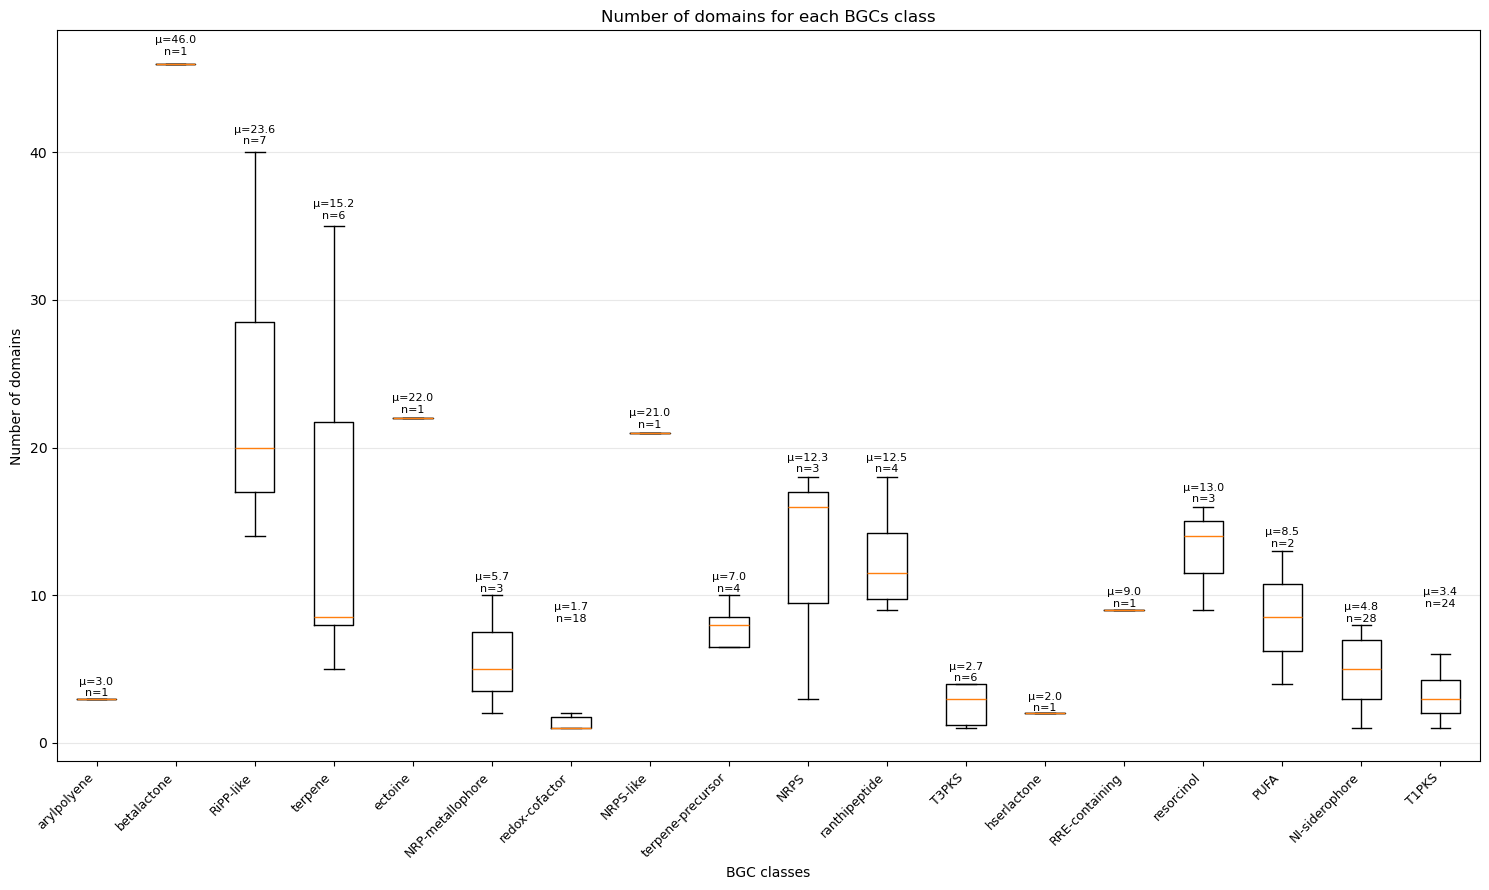

In [29]:
groups = [group["len_domains"].values for _, group in df_biosynthetic_genes.groupby("product")]
labels = df_biosynthetic_genes["product"].unique()

fig, ax = plt.subplots(figsize = (15,9)) 

for i, group in enumerate(groups, start=1):
    mean_val = np.mean(group)
    n = len(group)

    ax.text(
        i,
        max(group) * 1.01,  
        f"μ={mean_val:.1f}\nn={n}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.grid(True, linestyle='-', axis="y", color='lightgrey', alpha=0.5)
plt.boxplot(groups, labels=labels, showfliers=False)
plt.xticks(rotation=45, ha = "right", fontsize = 9)
plt.ylabel("Number of domains")
plt.xlabel("BGC classes")
plt.title("Number of domains for each BGCs class")
plt.tight_layout()
plt.show()

In [30]:
df_biosynthetic_genes_most_present_classes = df_biosynthetic_genes[
    df_biosynthetic_genes["product"].isin(classes)
]

/tmp/ipykernel_1137732/2604692985.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


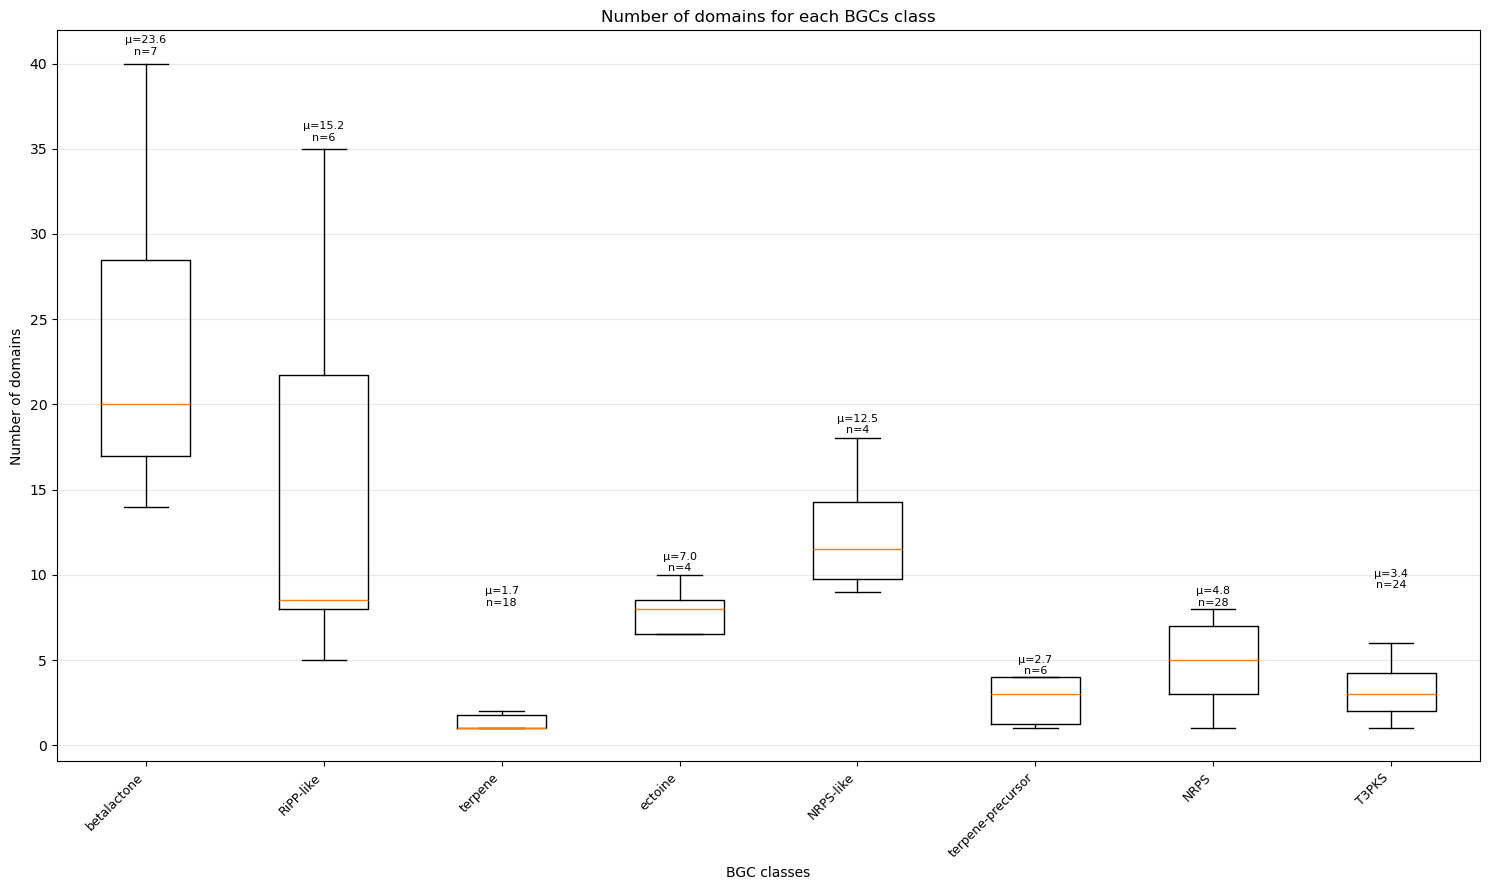

In [31]:
groups = [group["len_domains"].values for _, group in df_biosynthetic_genes_most_present_classes.groupby("product")]
labels = df_biosynthetic_genes_most_present_classes["product"].unique()

fig, ax = plt.subplots(figsize = (15,9)) 

for i, group in enumerate(groups, start=1):
    mean_val = np.mean(group)
    n = len(group)

    ax.text(
        i,
        max(group) * 1.01,  
        f"μ={mean_val:.1f}\nn={n}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.grid(True, linestyle='-', axis="y", color='lightgrey', alpha=0.5)
plt.boxplot(groups, labels=labels, showfliers=False)
plt.xticks(rotation=45, ha = "right", fontsize = 9)
plt.ylabel("Number of domains")
plt.xlabel("BGC classes")
plt.title("Number of domains for each BGCs class")
plt.tight_layout()
plt.show()

### BGCs domain analysis - Architecture frequency

Here we will try to count the architecture frequency by making a matrix with all the domains for each BGC.

In [32]:
df_frequency_domains = df_biosynthetic_genes[["contig", "domain_architecture_clean", "product"]]
df_frequency_domains

,contig,domain_architecture_clean,product
0,MGYG000296065_60,"[Ketoacyl-synt_2, PP-binding, PP-binding, PP-b...",arylpolyene
1,MGYG000296008_22,"[AMP-binding, AMP-binding, HMGL-like, Abhydrol...",betalactone
2,MGYG000296049_664,[DUF692],RiPP-like
3,MGYG000296030_3,"[2-Hacid_dh_C, Aminotran_5, Aminotran_5, oMT, ...",terpene
4,MGYG000296065_278,[ectoine_synt],ectoine
...,...,...,...
109,MGYG000296040_1,"[MGT, PT_FPPS_like, delta12_cd03507, PT_phytoe...",RiPP-like
110,MGYG000296040_1,"[MGT, PT_FPPS_like, delta12_cd03507, PT_phytoe...",terpene
111,MGYG000296065_138,[DUF692],RiPP-like
112,MGYG000296065_40,"[Orn_DAP_Arg_deC, Orn_Arg_deC_N, HAD_2, Pkinas...",resorcinol


In [33]:
domain_matrix = (
    df_frequency_domains[["domain_architecture_clean"]]
    .explode("domain_architecture_clean")
    .pipe(lambda x: pd.crosstab(x.index, x["domain_architecture_clean"]))
)
domain_matrix

domain_architecture_clean,2-Hacid_dh_C,4HBT_2,A-OX,ACP,ACPS,ADH_N,ADH_zinc_N,AMP-binding,APE_KS1,APE_KS2,...,ectoine_synt,fabH,hglE,hyb_KS,ketoacyl-synt,oMT,p450,phytoene_synt,t2fas,ubiA
row_0,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,0,2,1,1,...,0,0,0,0,2,0,0,0,0,0
1,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
domain_matrix.to_csv("domain_matrix_columns.tsv", sep="\t")


In [ ]:
# Retirando classes raras (filtragem) - Será feito de duas formas:
# Primeira: Colocar as classes raras em uma coluna única.
# Segunda: Retirada completa dos domínios da contagem.

# Encontrando os domínios mais frequentes a partir da matriz.
domain_sums = domain_matrix.sum(axis=0)

domain_sums_df = (
    domain_sums
    .reset_index()
    .rename(columns={"index": "domain", 0: "total_count"})
)
domain_sums_df

,domain_architecture_clean,total_count
0,2-Hacid_dh_C,4
1,4HBT_2,2
2,A-OX,2
3,ACP,1
4,ACPS,2
...,...,...
134,oMT,2
135,p450,4
136,phytoene_synt,23
137,t2fas,4


### PCA analysis

In [82]:
rare_domains = domain_sums[domain_sums <= 2].index
domain_matrix["rare_domains"] = domain_matrix[rare_domains].sum(axis=1)
rare_domains


Index(['4HBT_2', 'A-OX', 'ACP', 'ACPS', 'APE_KS1', 'ATP-grasp', 'ATP-grasp_3',
       'Aldedh', 'Amidohydro_1', 'Autoind_synth', 'Beta_elim_lyase',
       'CTP_transf_like', 'Chal_sti_synt_C', 'Dala_Dala_lig_N', 'Fer2_4',
       'Flavoprotein', 'GATase_7', 'GST_C', 'GST_N_3', 'Glyco_tran_28_C',
       'Glyco_transf_28', 'Glyco_transf_9', 'Glycos_transf_1', 'IPPT',
       'IucA_IucC', 'Ketoacyl-synt_2', 'Lysine_decarbox', 'MGT',
       'MannoseP_isomer', 'NTP_transf_3', 'Orn_Arg_deC_N', 'Orn_DAP_Arg_deC',
       'Orn_monoox', 'PF00881', 'PKS_DH2', 'PP-binding_2', 'PTHR43273', 'PTPS',
       'PT_HPP', 'PUFA_KS', 'PhyH', 'Pkinase', 'Polyketide_cyc',
       'Polyketide_cyc2', 'Polysacc_synt', 'Ranthipeptide_rSAM_RRE',
       'RmlD_sub_bind', 'SCIFF', 'TD', 'TIGR03798', 'TIGR03973',
       'TPP_enzyme_N', 'TP_methylase', 'ThiF', 'Thurincin_rSAM_RRE', 'Wzy_C',
       'YcaO', 'delta12_cd03507', 'delta9_cd03505', 'hglE', 'oMT', 'ubiA'],
      dtype='object', name='domain_architecture_clean')

In [83]:
domain_matrix_without_rare_domains = domain_matrix.drop(columns=rare_domains)


In [84]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(domain_matrix_without_rare_domains)


In [85]:
df_pca = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"],
    index=domain_matrix_without_rare_domains.index
)

In [ ]:
# Variância do PCA por eixo:
pca.explained_variance_ratio_


array([0.44252983, 0.13961735])

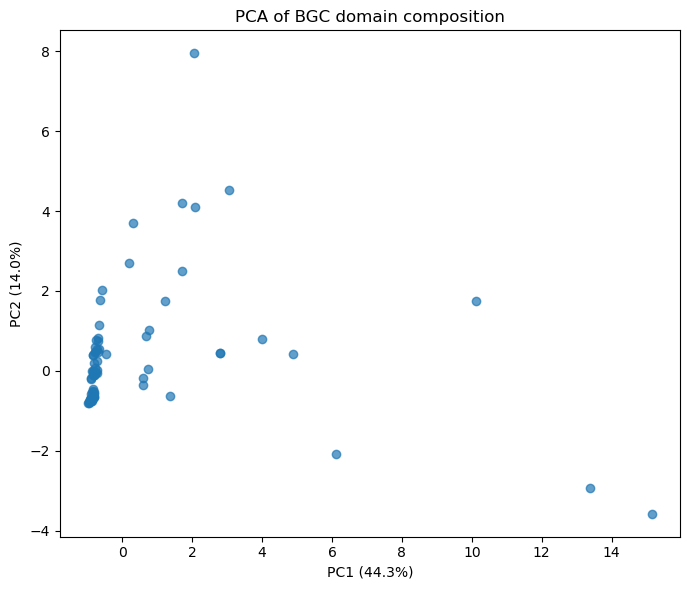

In [87]:
plt.figure(figsize=(7, 6))
plt.scatter(df_pca["PC1"], df_pca["PC2"], alpha=0.7)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of BGC domain composition")
plt.tight_layout()
plt.show()

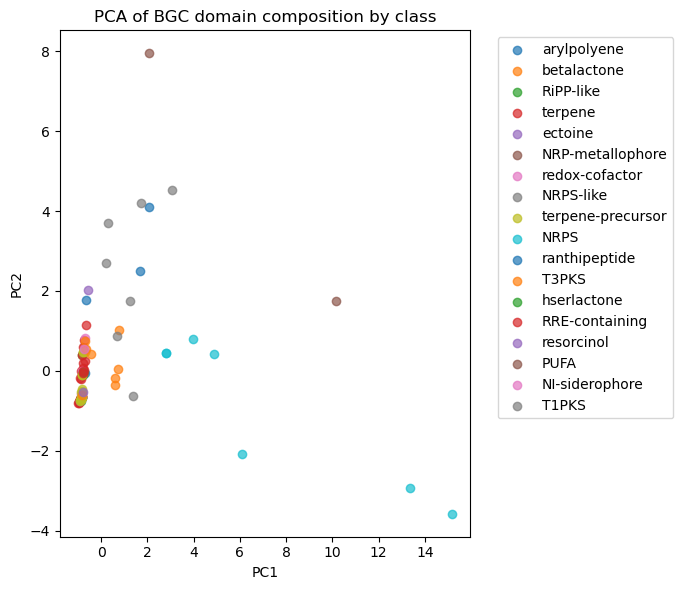

In [88]:
df_pca["class"] = df_frequency_domains["product"]

plt.figure(figsize=(7, 6))

for c in df_pca["class"].unique():
    sub = df_pca[df_pca["class"] == c]
    plt.scatter(sub["PC1"], sub["PC2"], label=c, alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of BGC domain composition by class")
plt.tight_layout()
plt.show()



In [89]:
# PCA com 3 componentes
pca = PCA(n_components=3)
pca_scores = pca.fit_transform(domain_matrix_without_rare_domains)

# DataFrame com os scores
df_pca = pd.DataFrame(
    pca_scores,
    columns=["PC1", "PC2", "PC3"],
    index=domain_matrix_without_rare_domains.index
)

# Variância explicada
print(pca.explained_variance_ratio_)
print("Variância acumulada:", pca.explained_variance_ratio_.sum())

[0.44252983 0.13961735 0.07167154]
Variância acumulada: 0.6538187249956129


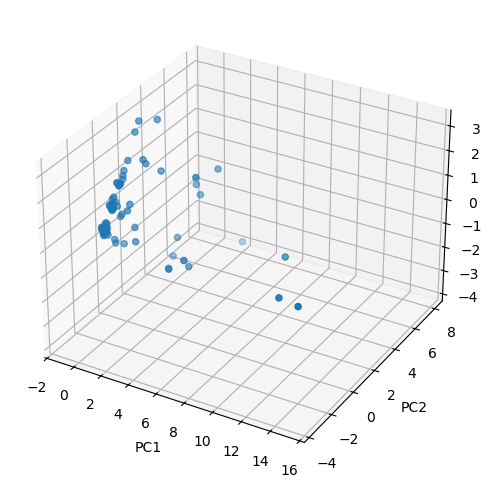

In [90]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    df_pca["PC1"],
    df_pca["PC2"],
    df_pca["PC3"]
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.show()


In [ ]:
!conda install -c conda-forge plotly

2 channel Terms of Service accepted
Channels:
 - conda-forge
 - ursky
 - bioconda
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.9.1
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/pedro/miniconda3/envs/antismash

  added / updated specs:
    - plotly


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    narwhals-2.14.0            |     pyhcf101f3_0         265 KB  conda-forge
    plotly-6.5.0               |     pyhd8ed1ab_0         4.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.2 MB

The following NEW packages will be INSTALLED:

  narwhals           conda-forge/noarch::narwhals-2.14.0-pyhcf101f3_

In [92]:
import plotly.express as px

fig = px.scatter_3d(
    df_pca,
    x="PC1",
    y="PC2",
    z="PC3",
    hover_name=df_pca.index
)

fig.show()



ModuleNotFoundError: No module named 'plotly'